## Libraries

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Concatenate, LayerNormalization
from keras.layers import GlobalAveragePooling1D, MultiHeadAttention, Flatten, BatchNormalization, MaxPooling1D, Flatten, LSTM, Bidirectional, Reshape
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop, Adamax, AdamW
from keras.utils import to_categorical
from keras.regularizers import L1L2
from keras.initializers import RandomNormal
from keras.constraints import UnitNorm
from keras.callbacks import EarlyStopping
import ast

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

## Data preparation

In [164]:
train_data = pd.read_csv('../../../Data/labelled_training_data.csv')
val_data = pd.read_csv('../../../Data/labelled_validation_data.csv')
test_data = pd.read_csv('../../../Data/labelled_testing_data.csv')

In [165]:
train_data["processId"] = train_data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_data["parentProcessId"] = train_data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_data["userId"] = train_data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
train_data["mountNamespace"] = train_data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
train_data["eventId"] = train_data["eventId"]  # Keep eventId values (requires knowing max value)
train_data["returnValue"] = train_data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))


val_data["processId"] = val_data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
val_data["parentProcessId"] = val_data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
val_data["userId"] = val_data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
val_data["mountNamespace"] = val_data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
val_data["eventId"] = val_data["eventId"]  # Keep eventId values (requires knowing max value)
val_data["returnValue"] = val_data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))


test_data["processId"] = test_data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
test_data["parentProcessId"] = test_data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
test_data["userId"] = test_data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
test_data["mountNamespace"] = test_data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
test_data["eventId"] = test_data["eventId"]  # Keep eventId values (requires knowing max value)
test_data["returnValue"] = test_data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))

In [166]:
train_data.describe()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus,evil
count,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.0
mean,1844.582673,0.978617,6820.265241,0.895755,0.001305,0.256371,288.158953,2.672082,0.340016,0.001663,0.0
std,1136.638249,0.144656,1937.068333,0.305578,0.036103,0.436629,385.117778,1.340906,0.533623,0.040744,0.0
min,132.560721,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.0
25%,903.250802,1.000000,7313.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.0
50%,1829.203642,1.000000,7365.000000,1.000000,0.000000,0.000000,62.000000,3.000000,0.000000,0.000000,0.0
75%,2761.380825,1.000000,7415.000000,1.000000,0.000000,1.000000,257.000000,4.000000,1.000000,0.000000,0.0
max,3954.587643,1.000000,8619.000000,1.000000,1.000000,1.000000,1010.000000,5.000000,2.000000,1.000000,0.0


In [167]:
train_data.dtypes

timestamp          float64
processId            int64
threadId             int64
parentProcessId      int64
userId               int64
mountNamespace       int64
processName         object
hostName            object
eventId              int64
eventName           object
stackAddresses      object
argsNum              int64
returnValue          int64
args                object
sus                  int64
evil                 int64
dtype: object

### **Stackaddress**

In [168]:
stack_addresses_df = pd.concat([train_data['stackAddresses'], val_data['stackAddresses'], test_data['stackAddresses']], axis=0)
len(stack_addresses_df.unique())

112474

**Convert String to List**

In [169]:
# Convert string to list
train_data.stackAddresses = train_data.stackAddresses.apply(ast.literal_eval)
val_data.stackAddresses = val_data.stackAddresses.apply(ast.literal_eval)
test_data.stackAddresses = test_data.stackAddresses.apply(ast.literal_eval)
train_data.stackAddresses[0]

[140662171848350, 11649800180280676]

In [170]:
train_data['stack_address_len']=train_data.stackAddresses.apply(len)
val_data['stack_address_len']=val_data.stackAddresses.apply(len)
test_data['stack_address_len']=test_data.stackAddresses.apply(len)
print(f"Training dataset - Max length of stack addresses: {max(train_data['stack_address_len'])}")
print(f"Validation dataset - Max length of stack addresses: {max(val_data['stack_address_len'])}")
print(f"Testing dataset - Max length of stack addresses: {max(test_data['stack_address_len'])}")

Training dataset - Max length of stack addresses: 20
Validation dataset - Max length of stack addresses: 20
Testing dataset - Max length of stack addresses: 20


In [171]:
train_data['stack_address_len'].value_counts()

stack_address_len
0     521115
2     109594
1      65545
3      59301
4       2445
20      1406
14      1073
15       932
6        354
8        347
17       276
10       206
11       190
9        143
5         92
16        90
12        27
7          8
Name: count, dtype: int64

**Split list**

In [172]:
for i in range(max(train_data['stack_address_len'])):
    train_data[f"stack_{i+1}"]=""
    val_data[f"stack_{i+1}"]=""
    test_data[f"stack_{i+1}"]=""

In [173]:
for index, row in train_data.iterrows():
    list_stack = [float(elem) for elem in row['stackAddresses']]
    for i, elem in enumerate(list_stack):
        train_data.at[index, f'stack_{i+1}'] = elem

for index, row in val_data.iterrows():
    list_stack = [float(elem) for elem in row['stackAddresses']]
    for i, elem in enumerate(list_stack):
        val_data.at[index, f'stack_{i+1}'] = elem


for index, row in test_data.iterrows():
    list_stack = [float(elem) for elem in row['stackAddresses']]
    for i, elem in enumerate(list_stack):
        test_data.at[index, f'stack_{i+1}'] = elem

**Args**

In [174]:
train_data['argsNum'].value_counts()

argsNum
4    359113
1    230609
2    149273
3     20062
5      2678
0      1409
Name: count, dtype: int64

In [175]:
len(train_data['args'].unique())

214720

In [176]:
train_data['args'][4]

"[{'name': 'pathname', 'type': 'const char*', 'value': '/etc/ld.so.cache'}, {'name': 'flags', 'type': 'int', 'value': 'O_RDONLY|O_LARGEFILE'}, {'name': 'dev', 'type': 'dev_t', 'value': 211812353}, {'name': 'inode', 'type': 'unsigned long', 'value': 62841}]"

**Split args**

In [177]:
# Function to split the string column into list of dictionaries and create new columns
def split_and_expand(row):
    if pd.isna(row):
        return pd.Series([None] * 15)

    dicts = ast.literal_eval(row)
    result = {'name_{}'.format(i+1): None for i in range(5)}
    result.update({'type_{}'.format(i+1): None for i in range(5)})
    result.update({'value_{}'.format(i+1): None for i in range(5)})

    for i, d in enumerate(dicts):
        if i >= 5:
            break
        result['name_{}'.format(i+1)] = d.get('name')
        result['type_{}'.format(i+1)] = d.get('type')
        result['value_{}'.format(i+1)] = d.get('value')

    return pd.Series(result)

Training

In [178]:
args_split = train_data['args'].apply(split_and_expand)
train_data = pd.concat([train_data, args_split], axis=1)

Validation

In [179]:
args_split = val_data['args'].apply(split_and_expand)
val_data = pd.concat([val_data, args_split], axis=1)

Testing

In [180]:
args_split = test_data['args'].apply(split_and_expand)
test_data = pd.concat([test_data, args_split], axis=1)

In [181]:
processid_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1, dtype=float)

train_data[['processId']] = processid_ordinal_encoder.fit_transform(train_data[['processId']])
val_data[['processId']] = processid_ordinal_encoder.transform(val_data[['processId']])
test_data[['processId']] = processid_ordinal_encoder.transform(test_data[['processId']])

In [182]:
threadid_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1, dtype=float)

train_data[['threadId']] = threadid_ordinal_encoder.fit_transform(train_data[['threadId']])
val_data[['threadId']] = threadid_ordinal_encoder.transform(val_data[['threadId']])
test_data[['threadId']] = threadid_ordinal_encoder.transform(test_data[['threadId']])

In [183]:
parentProcessId_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1, dtype=float)

train_data[['parentProcessId']] = parentProcessId_ordinal_encoder.fit_transform(train_data[['parentProcessId']])
val_data[['parentProcessId']] = parentProcessId_ordinal_encoder.transform(val_data[['parentProcessId']])
test_data[['parentProcessId']] = parentProcessId_ordinal_encoder.transform(test_data[['parentProcessId']])

In [184]:
userId_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1, dtype=float)

train_data[['userId']] = userId_ordinal_encoder.fit_transform(train_data[['userId']])
val_data[['userId']] = userId_ordinal_encoder.transform(val_data[['userId']])
test_data[['userId']] = userId_ordinal_encoder.transform(test_data[['userId']])

In [185]:
mountNamespace_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1, dtype=float)

train_data[['mountNamespace']] = mountNamespace_ordinal_encoder.fit_transform(train_data[['mountNamespace']])
val_data[['mountNamespace']] = mountNamespace_ordinal_encoder.transform(val_data[['mountNamespace']])
test_data[['mountNamespace']] = mountNamespace_ordinal_encoder.transform(test_data[['mountNamespace']])

In [186]:
hostName_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1, dtype=float)

train_data[['hostName']] = hostName_ordinal_encoder.fit_transform(train_data[['hostName']])
val_data[['hostName']] = hostName_ordinal_encoder.transform(val_data[['hostName']])
test_data[['hostName']] = hostName_ordinal_encoder.transform(test_data[['hostName']])

In [187]:
eventId_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1, dtype=float)

train_data[['eventId']] = eventId_ordinal_encoder.fit_transform(train_data[['eventId']])
val_data[['eventId']] = eventId_ordinal_encoder.transform(val_data[['eventId']])
test_data[['eventId']] = eventId_ordinal_encoder.transform(test_data[['eventId']])

In [188]:
returnValue_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1, dtype=float)

train_data[['returnValue']] = returnValue_ordinal_encoder.fit_transform(train_data[['returnValue']])
val_data[['returnValue']] = returnValue_ordinal_encoder.transform(val_data[['returnValue']])
test_data[['returnValue']] = returnValue_ordinal_encoder.transform(test_data[['returnValue']])

In [189]:
stack_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1, dtype=float)

# Encode Stack adresses
stackaddresses_train_enc = stack_ordinal_encoder.fit_transform(train_data[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                                                      'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                                                      'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                                                      'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']].astype('str'))

train_data[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
             'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
             'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
             'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']] = stackaddresses_train_enc

stackaddresses_val_enc = stack_ordinal_encoder.transform(val_data[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                                        'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                                        'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                                        'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']].astype('str'))
stackaddresses_val_enc = np.where(stackaddresses_val_enc==-1, np.max(stackaddresses_train_enc)+1, stackaddresses_val_enc)
val_data[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
           'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
           'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
           'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']]= stackaddresses_val_enc

stackaddresses_test_enc = stack_ordinal_encoder.transform(test_data[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                                        'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                                        'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                                        'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']].astype('str'))

stackaddresses_test_enc = np.where(stackaddresses_test_enc==-1, np.max(stackaddresses_train_enc)+1, stackaddresses_test_enc)

test_data[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
           'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
           'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
           'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']]= stackaddresses_test_enc

In [190]:
# Encode Stack adresses
args_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=float)
args_train_enc = args_ordinal_encoder.fit_transform(train_data[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                                            'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                                            'value_1', 'value_2', 'value_3', 'value_4', 'value_5']].astype('str'))
train_data[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
             'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
             'value_1', 'value_2', 'value_3', 'value_4', 'value_5']] = args_train_enc

args_val_enc = args_ordinal_encoder.transform(val_data[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                                    'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                                    'value_1', 'value_2', 'value_3', 'value_4', 'value_5']].astype('str'))

args_val_enc = np.where(args_val_enc==-1, np.max(args_train_enc)+1, args_val_enc)

val_data[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
           'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
           'value_1', 'value_2', 'value_3', 'value_4', 'value_5']] = args_val_enc

args_test_enc = args_ordinal_encoder.transform(test_data[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                                      'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                                      'value_1', 'value_2', 'value_3', 'value_4', 'value_5']].astype('str'))

args_test_enc = np.where(args_test_enc==-1, np.max(args_train_enc)+1, args_test_enc)

test_data[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
           'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
           'value_1', 'value_2', 'value_3', 'value_4', 'value_5']] = args_test_enc

In [191]:
y_train = train_data['sus']
y_val = val_data['sus']
y_test = test_data['sus']
y_train_encoded = to_categorical(train_data['sus'], num_classes=2)
y_val_encoded = to_categorical(val_data['sus'], num_classes=2)
y_test_encoded = to_categorical(test_data['sus'], num_classes=2)
y_train_encoded

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

## Modelisation

In [192]:
n_unique_stack = (np.max(stackaddresses_train_enc)+2).astype('int')
n_unique_args = (np.max(args_train_enc)+2).astype('int')
n_unique_processId = (np.max(train_data[['processId']])+2).astype('int')
n_unique_threadId = (np.max(train_data[['threadId']])+2).astype('int')
n_unique_parentProcessId = (np.max(train_data[['parentProcessId']])+2).astype('int')
n_unique_userId = (np.max(train_data[['userId']])+2).astype('int')
n_unique_mountNamespace = (np.max(train_data[['mountNamespace']])+2).astype('int')
n_unique_hostname = (np.max(train_data[['hostName']])+2).astype('int')
n_unique_eventid = (np.max(train_data[['eventId']])+2).astype('int')
n_unique_returnvalue = (np.max(train_data[['returnValue']])+2).astype('int')

print(n_unique_stack, n_unique_args, n_unique_processId, n_unique_threadId, n_unique_parentProcessId, 
n_unique_userId, n_unique_mountNamespace, n_unique_hostname, n_unique_eventid, n_unique_returnvalue)

8449 26665 3 589 3 3 3 9 33 4


In [193]:
train_data.columns

Index(['timestamp', 'processId', 'threadId', 'parentProcessId', 'userId',
       'mountNamespace', 'processName', 'hostName', 'eventId', 'eventName',
       'stackAddresses', 'argsNum', 'returnValue', 'args', 'sus', 'evil',
       'stack_address_len', 'stack_1', 'stack_2', 'stack_3', 'stack_4',
       'stack_5', 'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
       'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15', 'stack_16',
       'stack_17', 'stack_18', 'stack_19', 'stack_20', 'name_1', 'name_2',
       'name_3', 'name_4', 'name_5', 'type_1', 'type_2', 'type_3', 'type_4',
       'type_5', 'value_1', 'value_2', 'value_3', 'value_4', 'value_5'],
      dtype='object')

In [202]:
def create_transformer_model(stack_vocab, args_vocab, processid_vocab,
                             threadid_vocab, parentprocessid_vocab,
                             userid_vocab, mountnamespace_vocab, hostname_vocab,
                             eventid_vocab, returnvalue_vocab, max_len=10):

  # Define inputs 
  input_stack = Input(shape=(20,))
  input_args = Input(shape=(15,))
  input_processid = Input(shape=(1,))
  input_threadid = Input(shape=(1,))
  input_parentprocessid = Input(shape=(1,))
  input_userid = Input(shape=(1,))
  input_mountnamespace = Input(shape=(1,))
  input_hostname = Input(shape=(1,))
  input_eventid = Input(shape=(1,))
  input_returnvalue = Input(shape=(1,))
  input_args_num = Input(shape=(1,))
  input_stacks_len = Input(shape=(1,))

  # Define embedding layers for categorical features
  embedding_size1 = 256
  embedding_size2 = 32
  hidden_size = 64
  embed_stack = Embedding(input_dim=stack_vocab,
                         output_dim=embedding_size1,
                        #  embeddings_initializer = RandomNormal(mean=0.0, stddev=0.0001, seed=41),
                        #  embeddings_regularizer = L1L2(l1=0.0001, l2=0.0001),
                        #  embeddings_constraint  = UnitNorm(axis=[0,1]),
                         mask_zero=False)(input_stack)
  embed_cat1 = Dense(hidden_size, activation='linear')(embed_stack)

  embed_args = Embedding(input_dim=args_vocab,
                         output_dim=embedding_size1,
                        #  embeddings_initializer = RandomNormal(mean=0.0, stddev=0.0001, seed=41),
                        #  embeddings_regularizer = L1L2(l1=0.0001, l2=0.001),
                        #  embeddings_constraint  = UnitNorm(axis=[0,1]),
                         mask_zero=False)(input_args)
  embed_cat2 = Dense(hidden_size, activation='linear')(embed_args)

  embed_processid = Embedding(input_dim=processid_vocab,
                         output_dim=embedding_size2,
                        #  embeddings_initializer = RandomNormal(mean=0.0, stddev=0.0001, seed=41),
                        #  embeddings_regularizer = L1L2(l1=0.0001, l2=0.001),
                        #  embeddings_constraint  = UnitNorm(axis=[0,1]),
                         mask_zero=False)(input_processid)
  embed_cat3 = Dense(hidden_size, activation='linear')(embed_processid)

  embed_threadid = Embedding(input_dim=threadid_vocab,
                         output_dim=embedding_size2,
                        #  embeddings_initializer = RandomNormal(mean=0.0, stddev=0.0001, seed=41),
                        #  embeddings_regularizer = L1L2(l1=0.0001, l2=0.001),
                        #  embeddings_constraint  = UnitNorm(axis=[0,1]),
                         mask_zero=False)(input_threadid)
  embed_cat4 = Dense(hidden_size, activation='linear')(embed_threadid)

  embed_parentprocessid = Embedding(input_dim=parentprocessid_vocab,
                         output_dim=embedding_size2,
                        #  embeddings_initializer = RandomNormal(mean=0.0, stddev=0.0001, seed=41),
                        #  embeddings_regularizer = L1L2(l1=0.0001, l2=0.001),
                        #  embeddings_constraint  = UnitNorm(axis=[0,1]),
                         mask_zero=False)(input_parentprocessid)
  embed_cat5 = Dense(hidden_size, activation='linear')(embed_parentprocessid)

  embed_userid = Embedding(input_dim=userid_vocab,
                         output_dim=embedding_size2,
                        #  embeddings_initializer = RandomNormal(mean=0.0, stddev=0.0001, seed=41),
                        #  embeddings_regularizer = L1L2(l1=0.0001, l2=0.001),
                        #  embeddings_constraint  = UnitNorm(axis=[0,1]),
                         mask_zero=False)(input_userid)
  embed_cat6 = Dense(hidden_size, activation='linear')(embed_userid)

  embed_mountnamespace = Embedding(input_dim=mountnamespace_vocab,
                         output_dim=embedding_size2,
                        #  embeddings_initializer = RandomNormal(mean=0.0, stddev=0.0001, seed=41),
                        #  embeddings_regularizer = L1L2(l1=0.0001, l2=0.001),
                        #  embeddings_constraint  = UnitNorm(axis=[0,1]),
                         mask_zero=False)(input_mountnamespace)
  embed_cat7 = Dense(hidden_size, activation='linear')(embed_mountnamespace)

  embed_hostname = Embedding(input_dim=hostname_vocab,
                         output_dim=embedding_size2,
                        #  embeddings_initializer = RandomNormal(mean=0.0, stddev=0.0001, seed=41),
                        #  embeddings_regularizer = L1L2(l1=0.00001, l2=0.0001),
                        #  embeddings_constraint  = UnitNorm(axis=[0,1]),
                         mask_zero=False)(input_hostname)
  embed_cat8 = Dense(hidden_size, activation='linear')(embed_hostname)

  embed_eventid = Embedding(input_dim=eventid_vocab,
                         output_dim=embedding_size2,
                        #  embeddings_initializer = RandomNormal(mean=0.0, stddev=0.0001, seed=41),
                        #  embeddings_regularizer = L1L2(l1=0.0001, l2=0.0001),
                        #  embeddings_constraint  = UnitNorm(axis=[0,1]),
                         mask_zero=False)(input_eventid)
  embed_cat9 = Dense(hidden_size, activation='linear')(embed_eventid)

  embed_returnvalue = Embedding(input_dim=returnvalue_vocab,
                         output_dim=embedding_size2,
                        #  embeddings_initializer = RandomNormal(mean=0.0, stddev=0.0001, seed=41),
                        #  embeddings_regularizer = L1L2(l1=0.0001, l2=0.0001),
                        #  embeddings_constraint  = UnitNorm(axis=[0,1]),
                         mask_zero=False)(input_returnvalue)
  embed_cat10 = Dense(hidden_size, activation='linear')(embed_returnvalue)

  # numerical data
  num1 = Dense(hidden_size, activation='linear')(input_args_num)
  num1 = Reshape(target_shape=(1, hidden_size))(num1)
  num2 = Dense(hidden_size, activation='linear')(input_stacks_len)
  num2 = Reshape(target_shape=(1, hidden_size))(num2)


  # Concatenate embedding layers
  concat_embeds = Concatenate(axis=1)([embed_cat1, embed_cat2, embed_cat3, embed_cat4, 
                                       embed_cat5, embed_cat6, embed_cat7, embed_cat8,
                                       embed_cat9, embed_cat10, num1, num2])

  # Positional encoding (assuming you want to use sequences)
  max_len=45
  pos_encoding = PositionalEncoding(max_len, hidden_size)(concat_embeds)

  # Transformer encoder block
  encoder_output = transformer_encoder_block(pos_encoding, num_heads=4, ff_dim=hidden_size)

  # Global average pooling
  encoder_output = GlobalAveragePooling1D(keepdims=False)(encoder_output)
  
  x = Dense(512, activation='relu')(encoder_output)
  x = Dropout(0.2)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.2)(x)
#   x = Flatten()(x)
  output = Dense(2, activation='softmax')(x)
  # Define model
  model = Model(inputs=[input_stack, input_args, input_processid, input_threadid,
                        input_parentprocessid,input_userid, input_mountnamespace,
                        input_hostname, input_eventid, input_returnvalue,
                        input_args_num, input_stacks_len], outputs=output)

  return model

def transformer_encoder_block(inputs, num_heads, ff_dim, dropout_rate=0.2, embedding_size=128):
    # Multi-head self-attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_size)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-4)(inputs + attention)

    # Feed-forward layer
    outputs = Dense(ff_dim, activation='relu')(attention)
    outputs = Dropout(dropout_rate)(outputs)
    outputs = LayerNormalization(epsilon=1e-4)(attention + outputs)

    return outputs

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.positional_encoding = self.positional_encoding(sequence_length, output_dim)

    def call(self, inputs):
        return inputs + self.positional_encoding

    def positional_encoding(self, sequence_length, output_dim):
        encoded_vec = np.array([pos / np.power(100, 2 * i / output_dim) for pos in range(sequence_length) for i in range(output_dim)])
        encoded_vec[::2] = np.sin(encoded_vec[::2])
        encoded_vec[1::2] = np.cos(encoded_vec[1::2])
        return tf.constant(encoded_vec.reshape([sequence_length, output_dim]), dtype=tf.float32)

# Example usage
input_cat1_shape = 20
input_cat2_shape = 15
input_cat3_shape = 1
input_cat4_shape = 1
input_cat5_shape = 1
input_cat6_shape = 1
input_cat7_shape = 1
input_cat8_shape = 1
input_cat9_shape = 1
input_cat10_shape = 1

model = create_transformer_model(n_unique_stack, n_unique_args, n_unique_processId, n_unique_threadId, n_unique_parentProcessId,
                                 n_unique_userId, n_unique_mountNamespace, n_unique_hostname, n_unique_eventid, n_unique_returnvalue)

model.summary()


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_276     │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_277     │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_278     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_279     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_280     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_281     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_282     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_283     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_284     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_285     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_286     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_287     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_230       │ (None, 20, 256)   │  2,162,944 │ input_layer_276[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_231       │ (None, 15, 256)   │  6,826,240 │ input_layer_277[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_232       │ (None, 1, 32)     │         96 │ input_layer_278[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_233       │ (None, 1, 32)     │     18,848 │ input_layer_279[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_234       │ (None, 1, 32)     │         96 │ input_layer_280[

 Total params: 9,296,226 (35.46 MB)

 Trainable params: 9,296,226 (35.46 MB)

 Non-trainable params: 0 (0.00 B)

In [203]:
# optimizer = AdamW(learning_rate=0.0001, weight_decay=0.001)
optimizer = Adam(learning_rate=0.0000001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callback = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=False)

# Train the model
history = model.fit([train_data[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                 'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                 'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                 'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']],
                     train_data[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                 'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                 'value_1', 'value_2', 'value_3', 'value_4', 'value_5']],
                     train_data['processId'], train_data['threadId'], train_data['parentProcessId'],
                     train_data['userId'], train_data['mountNamespace'], train_data['hostName'],
                     train_data['eventId'], train_data['returnValue'],
                     train_data['argsNum'], train_data['stack_address_len']],
                    y_train_encoded,
                    epochs=50,  # Number of epochs
                    batch_size=512,  # Batch size
                    validation_data=([val_data[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                                'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                                'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                                'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']],
                                      val_data[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                                  'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                                  'value_1', 'value_2', 'value_3', 'value_4', 'value_5']],
                                      val_data['processId'], val_data['threadId'], val_data['parentProcessId'],
                                      val_data['userId'], val_data['mountNamespace'], val_data['hostName'],
                                      val_data['eventId'], val_data['returnValue'], 
                                      val_data['argsNum'], val_data['stack_address_len']],
                                     y_val_encoded),
                    verbose=1, shuffle=True, callbacks = [callback])

Epoch 1/50
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 348s 232ms/step - accuracy: 0.8047 - loss: 0.6324 - val_accuracy: 0.9958 - val_loss: 0.5622
Epoch 2/50
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 345s 232ms/step - accuracy: 0.9636 - loss: 0.5603 - val_accuracy: 0.9958 - val_loss: 0.4934
Epoch 3/50
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 346s 232ms/step - accuracy: 0.9944 - loss: 0.4961 - val_accuracy: 0.9958 - val_loss: 0.4316
Epoch 4/50
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 344s 231ms/step - accuracy: 0.9981 - loss: 0.4395 - val_accuracy: 0.9958 - val_loss: 0.3783
Epoch 5/50
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 347s 233ms/step - accuracy: 0.9983 - loss: 0.3905 - val_accuracy: 0.9958 - val_loss: 0.3323
Epoch 6/50
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 345s 231ms/step - accuracy: 0.9984 - loss: 0.3465 - val_accuracy: 0.9958 - val_loss: 0.2904
Epoch 7/50
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 347s 233ms/step - accuracy: 0.9982 - loss: 0.3065 - val_accuracy: 0.9958 - val_loss: 0.2551
Epoch 8/50
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 342s 229ms/step - ac

In [204]:
def plot_training(history):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Get the training and validation loss
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Plot the accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot the loss
    plt.figure(figsize=(8, 4))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    return(plt)

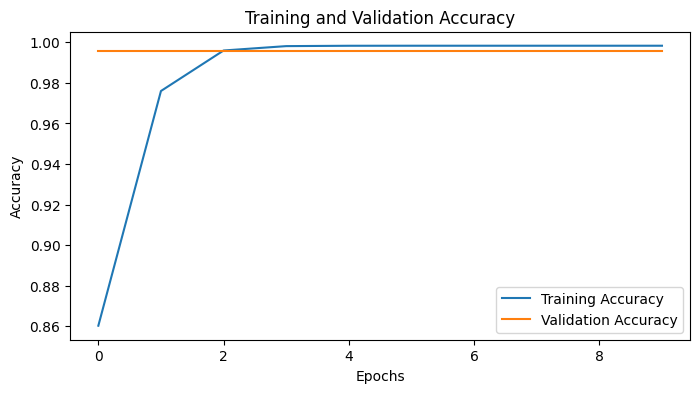

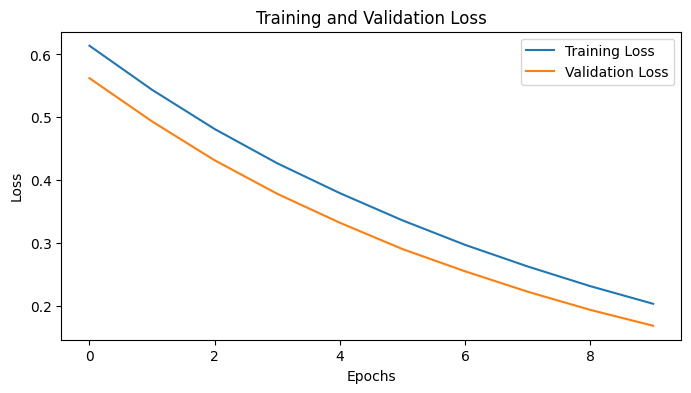

In [205]:
plot_training(history);

In [206]:
pred = model.predict([test_data[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                 'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                 'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                 'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']],
                      test_data[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                'value_1', 'value_2', 'value_3', 'value_4', 'value_5']],
                      test_data['processId'], test_data['threadId'], test_data['parentProcessId'],
                      test_data['userId'], test_data['mountNamespace'], test_data['hostName'],
                      test_data['eventId'], test_data['returnValue'],
                      test_data['argsNum'], test_data['stack_address_len']],
                     batch_size=256)

739/739 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step


In [207]:
model.evaluate(x=[test_data[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                 'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                 'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                 'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']],
                      test_data[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                'value_1', 'value_2', 'value_3', 'value_4', 'value_5']],
                      test_data['processId'], test_data['threadId'], test_data['parentProcessId'],
                      test_data['userId'], test_data['mountNamespace'], test_data['hostName'],
                      test_data['eventId'], test_data['returnValue'],
                      test_data['argsNum'], test_data['stack_address_len']], y=y_test_encoded)

5906/5906 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - accuracy: 0.2704 - loss: 1.4308


[1.738448143005371, 0.09265109896659851]

In [ ]:
# pred_threshold = np.where(pred>0.5,1,0)
pred_threshold = np.argmax(pred, axis=1)

In [ ]:
print(classification_report(y_test, pred_threshold))

              precision    recall  f1-score   support

           0       0.09      1.00      0.17     17508
           1       0.93      0.00      0.00    171459

    accuracy                           0.09    188967
   macro avg       0.51      0.50      0.09    188967
weighted avg       0.85      0.09      0.02    188967



In [ ]:
confusion_matrix(y_true=test_data['sus'], y_pred=pred_threshold)

array([[ 17508,      0],
       [171195,    264]])

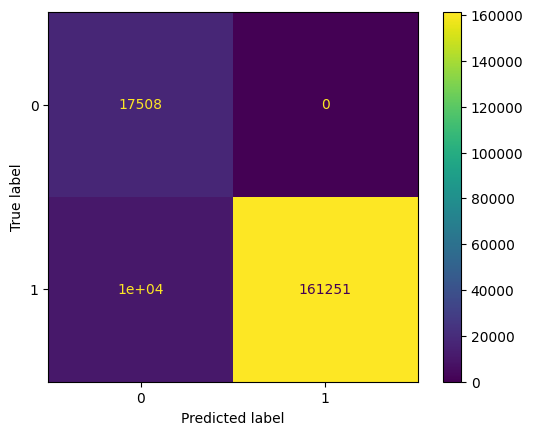

In [ ]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=pred_threshold)
x=ConfusionMatrixDisplay(conf_matrix).plot()

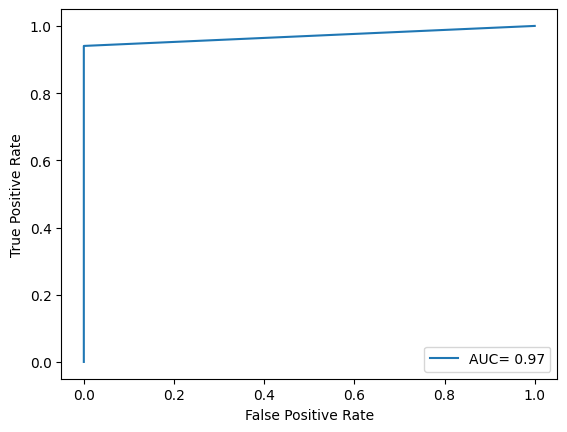

In [ ]:
auroc = roc_auc_score(y_true=y_test, y_score=pred_threshold)
fpr, tpr, _ = roc_curve(y_test, pred_threshold)
plt.plot(fpr,tpr,label=f"AUC= {auroc:.2f}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()